# HarvestStat Data Profiling - Burundi

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32736'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/BI_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Burundi',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | BI1982A1 | 15	| nan	| 0	| nan	| 0	|
| 1991	 | BI1991A1 | 16	| nan	| 0	| nan	| 0	|
| 1998	 | BI1998A1 | 17	| nan	| 0	| nan	| 0	|
| 2004	 | BI2004A1 | 17	| BI2004A2	| 129	| nan	| 0	|
| 2017	 | BI2017A1 | 18	| nan	| 0	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
df = df[df['admin_2'].isna()]

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([BI_Admin1_1982, BI_Admin1_1991, BI_Admin1_1998], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 12,142
Removed 463 "Missing Value" points
7,541/7,578 "Quantity Produced" points are retained.
2,283/2,283 "Area Planted" points are retained.
1,855/2,281 "Yield" points are retained.
Current data points: 11,679

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1996 - 2015
23 grain types are found: Banana (unspecified), Beans (mixed), Bush bean, Cassava, Cassava (non-bitter), Cooking Banana (unspecified), Cowpeas (Mixed), Groundnuts (In Shell), Maize (Corn), Millet (Finger), Pea (unspecified), Pigeon Peas, Pole bean, Potato (Irish), Rice (Paddy), Rice, not husked, Sorghum, Soybean (unspecified), Sunflower Seed, Sweet Potatoes, Taro, move to 1594AA, Wheat Grain, Yams
3 seasons are found: Season A (09-01), Season C (06-01), Season B (02-01)
1 crop production system are found: none
Data sources include:
[1] ISTEEBU, Burundi --- Annuaire Statistique, Buru

- Burundi crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-burundi%20%281%29.png?itok=v2zPE4Fr"  width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/eafrica_by_calendar.png"  width=900>

- comparison of boundaries

<img src="../figures/BI_admin_shapes.png"  width=900>

- In Burundi, basd on the FEWS NET data, there were four times of changes in administrative units: 1991,1998,2004,2017

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982	 | BI1982A1 | 15	| nan	| 0	|
| 1991	 | BI1991A1 | 16	| nan	| 0	|
| 1998	 | BI1998A1 | 17	| nan	| 0	|
| 2004	 | BI2004A1 | 17	| BI2004A2	| 129	|
| 2017	 | BI2017A1 | 18	| nan	| 0	|

- Here, we use **`BI1998A1`** to represent all admin-level 1 crop data because although there are 2004 and 2017 file, they don't appear to be used (e.g. no corresponding FNIDs)
- The data is available at admin level 1
- At admin-level 1,five crops have three seasons`Season A`,`Season B`,and `Season C`;Rice, not husked only has two seasons `Season A`and`Season B`

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = BI_Admin1_1998.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(BI_Admin1_1982,BI_Admin1_1998, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1991, over_1991 = FDW_PD_CreateAdminLink(BI_Admin1_1991,BI_Admin1_1998, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, prod, over_1982, mdx_pss)
link_ratio_1991 = FDW_PD_RatioAdminLink(link_1991, prod, over_1991, mdx_pss)

# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_1991.keys()
link_merged = [link_ratio_1991]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'BI1982A102' as no record found in: ['BI1998A102']
CBR is considered for 'BI1991A102' as no record found in: ['BI1998A102']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


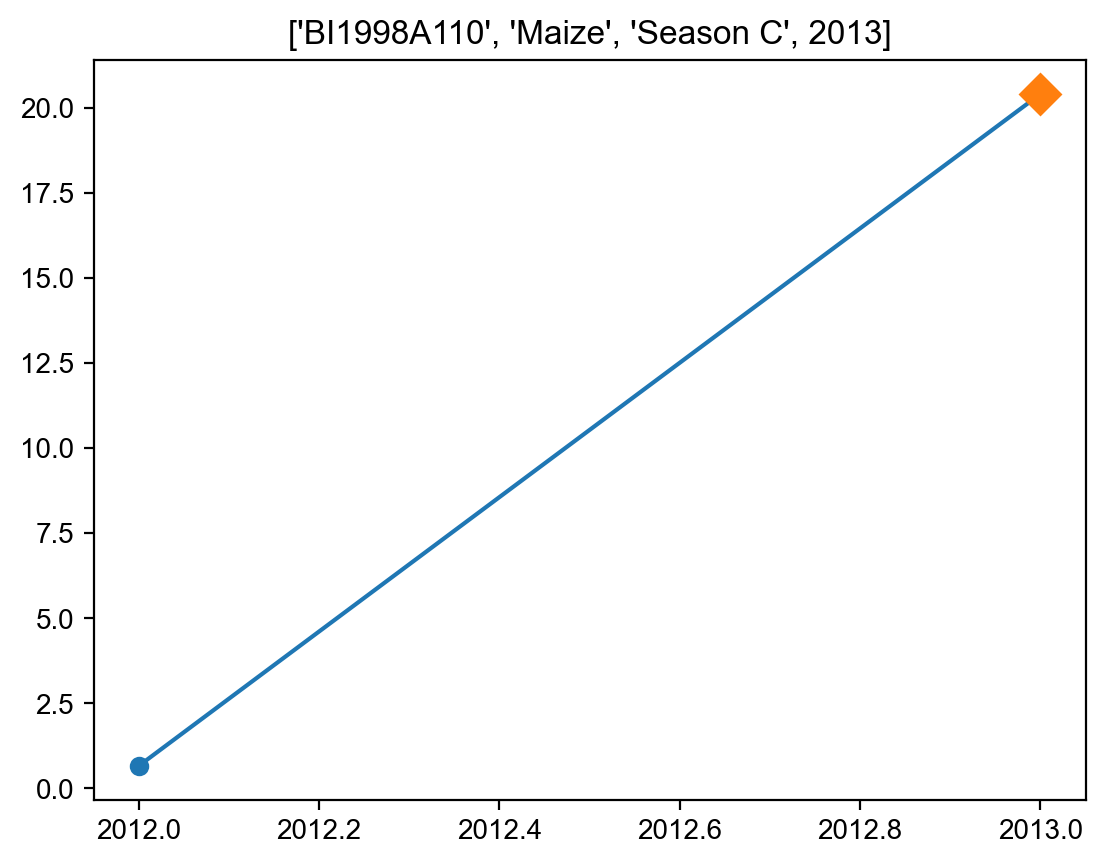

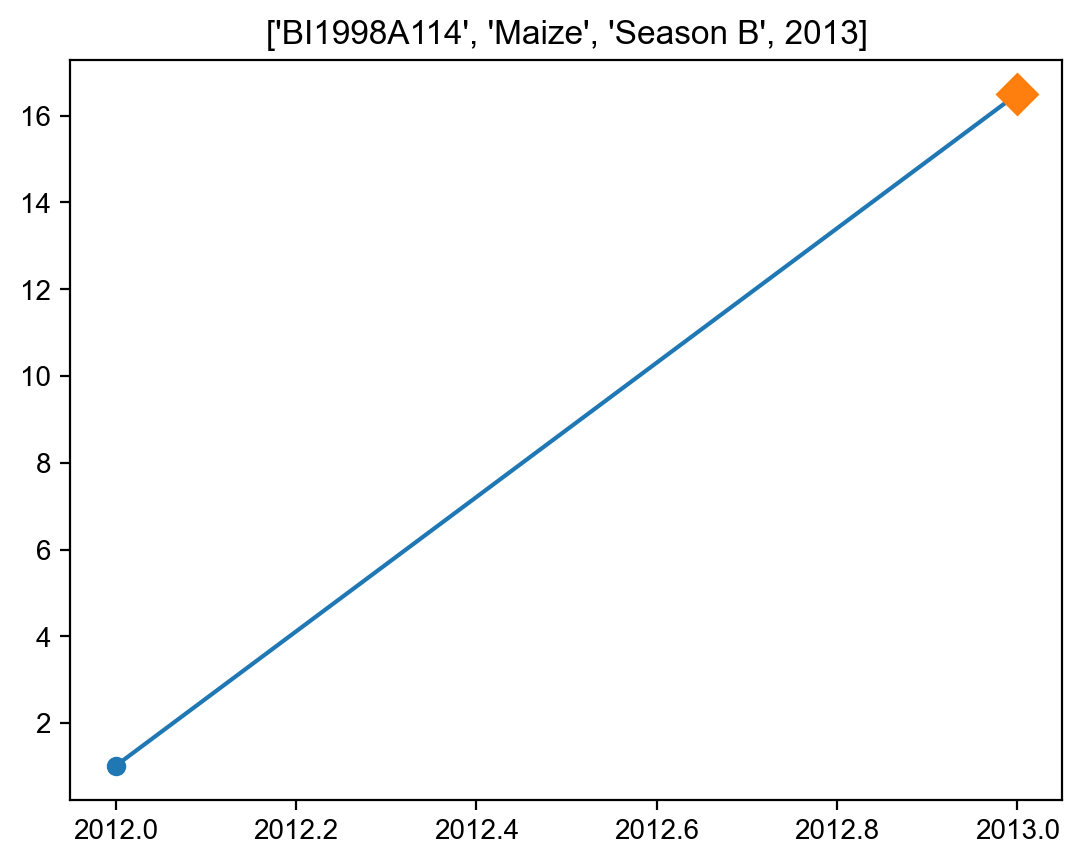

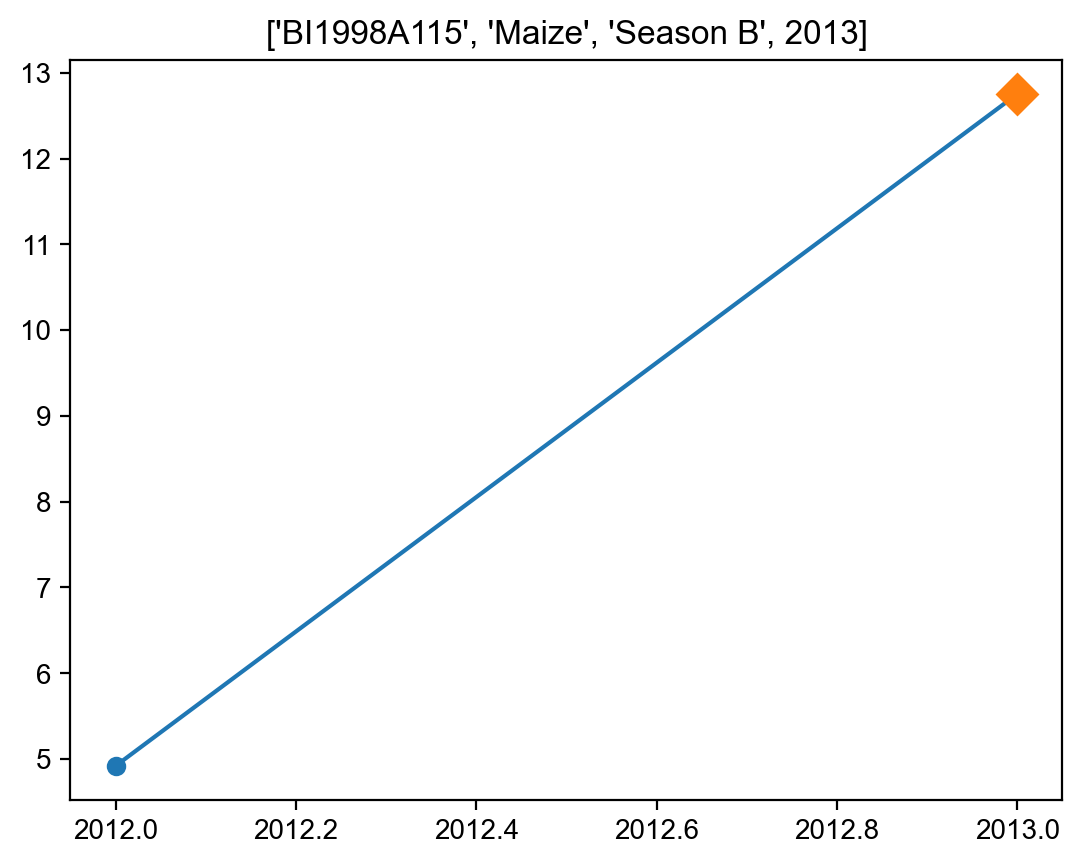

In [7]:
from matplotlib import pyplot as plt

outliers = [
            ['BI1998A110','Maize','Season C',2013],
            ['BI1998A114','Maize','Season B',2013],
            ['BI1998A115','Maize','Season B',2013],
]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_BI.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_BI_ratio.npz', link_ratio)

../data/crop/adm_crop_production_BI.csv is saved.
../data/crop/adm_crop_production_BI_ratio.npz is saved.


# Visualization of production data

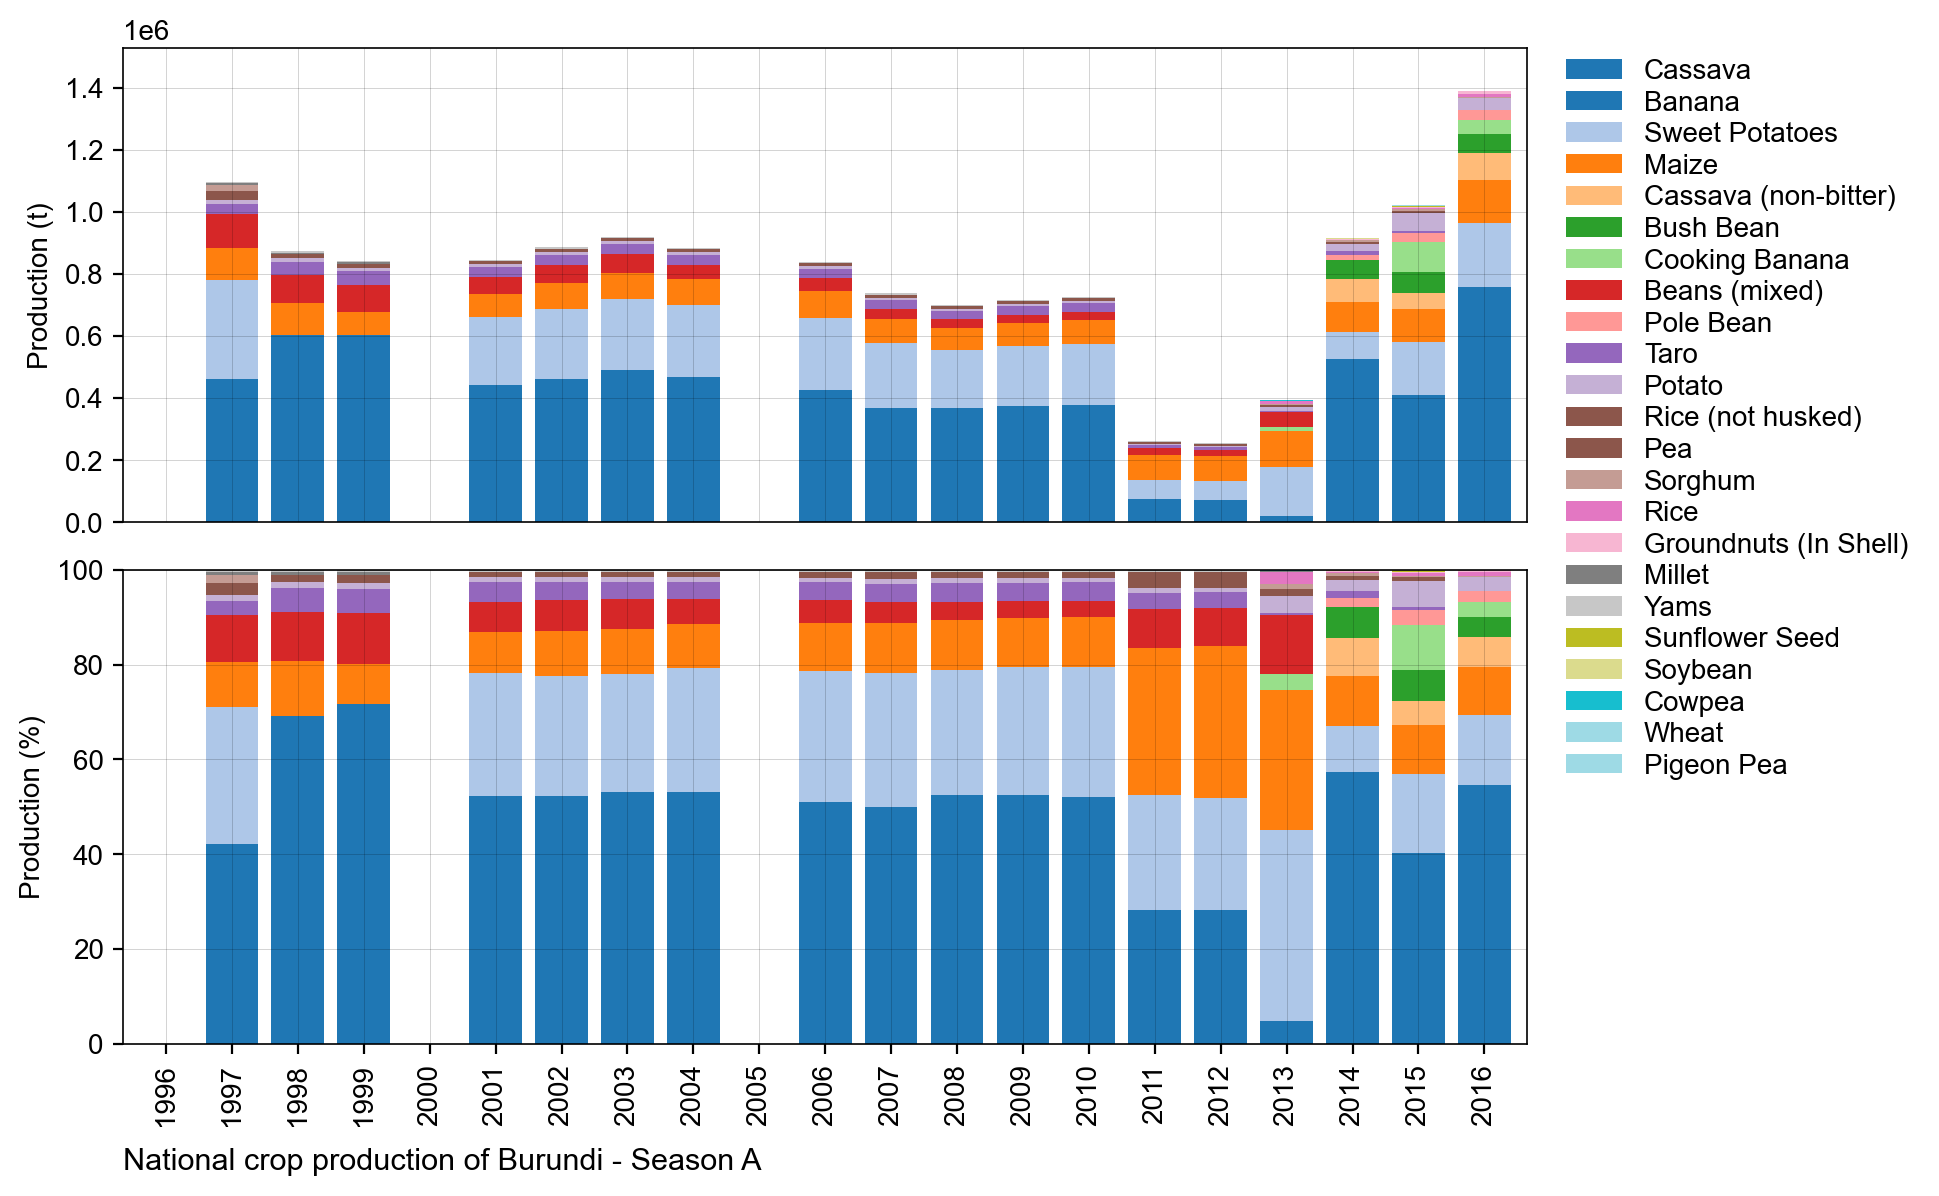

../figures/BI_bar_natgrainprod_Season A.png is saved.


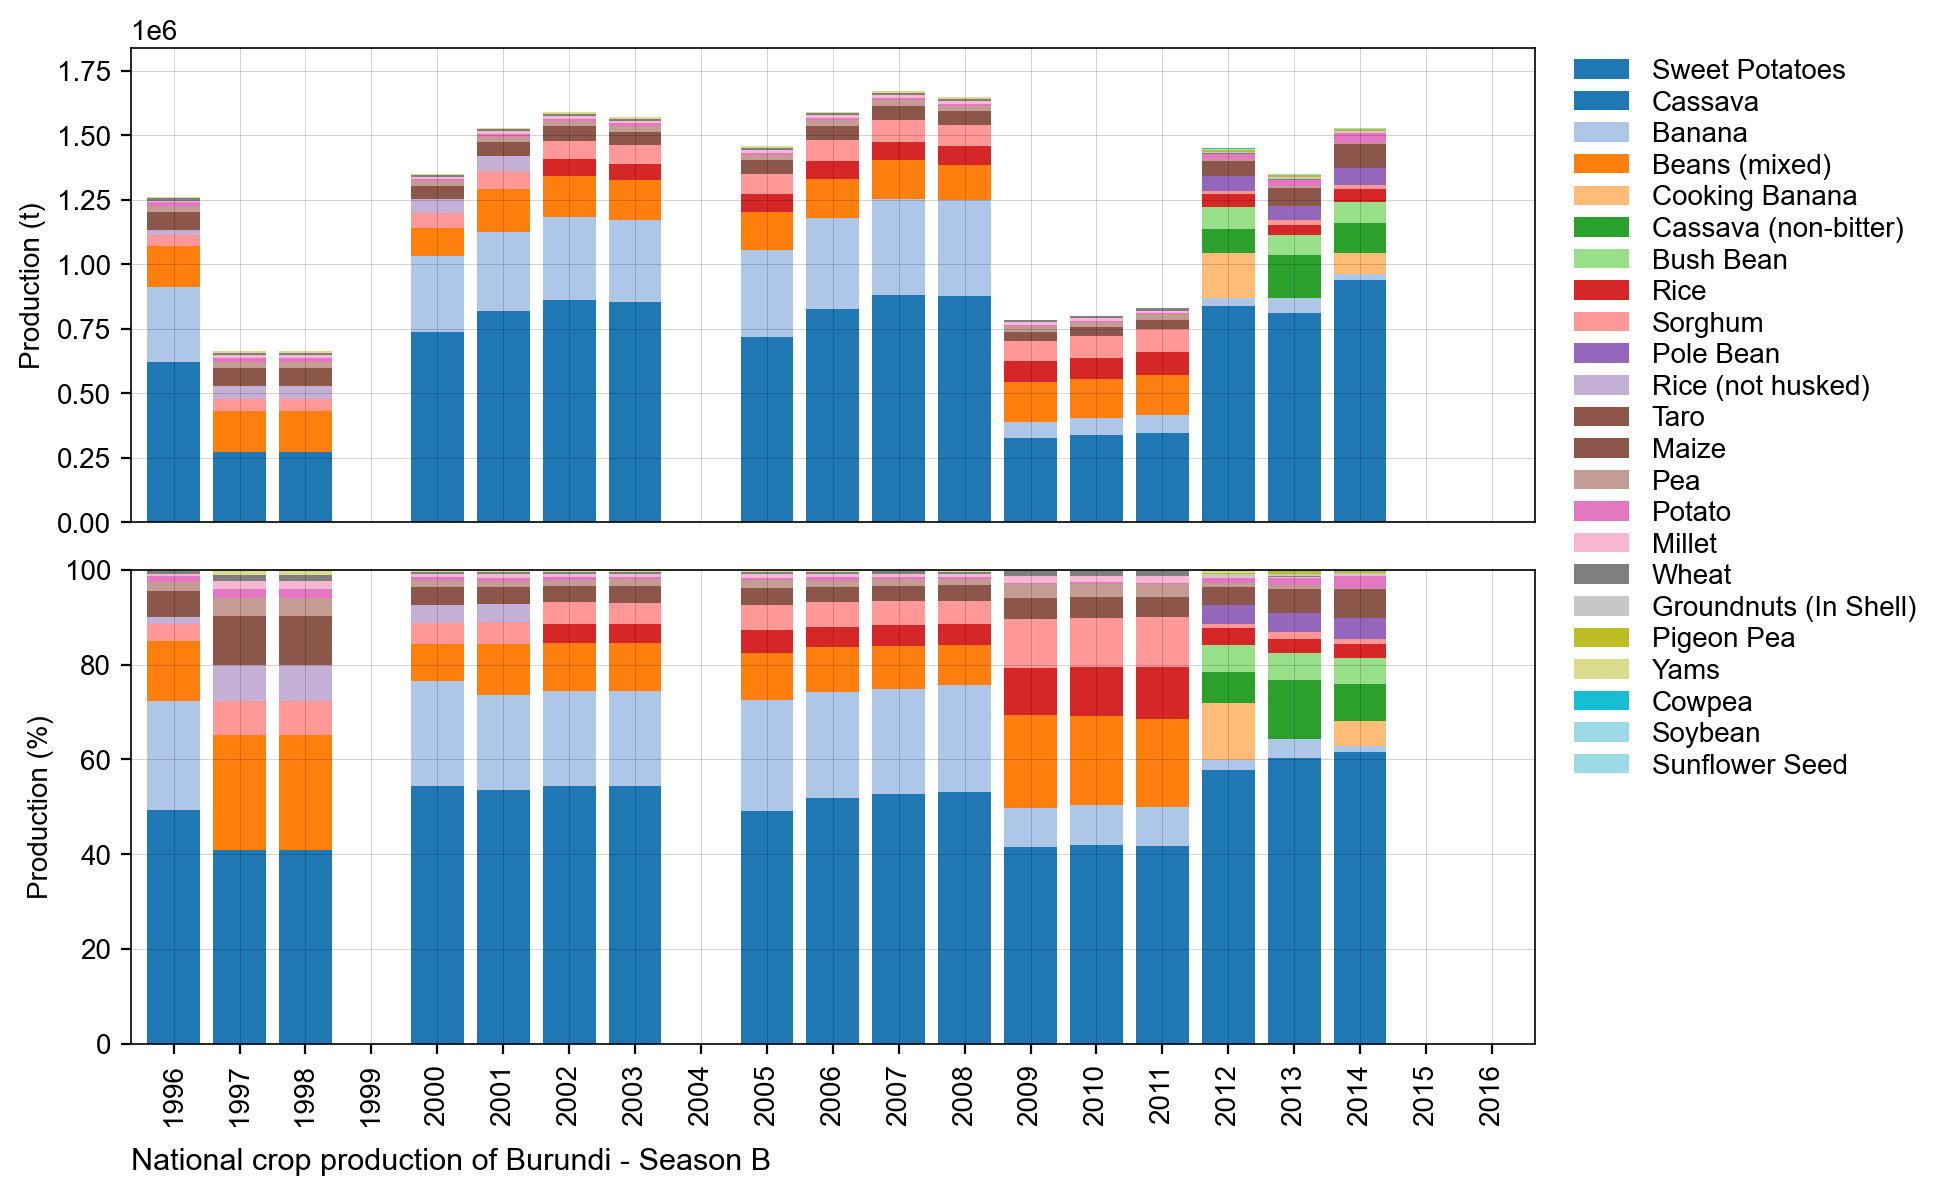

../figures/BI_bar_natgrainprod_Season B.png is saved.


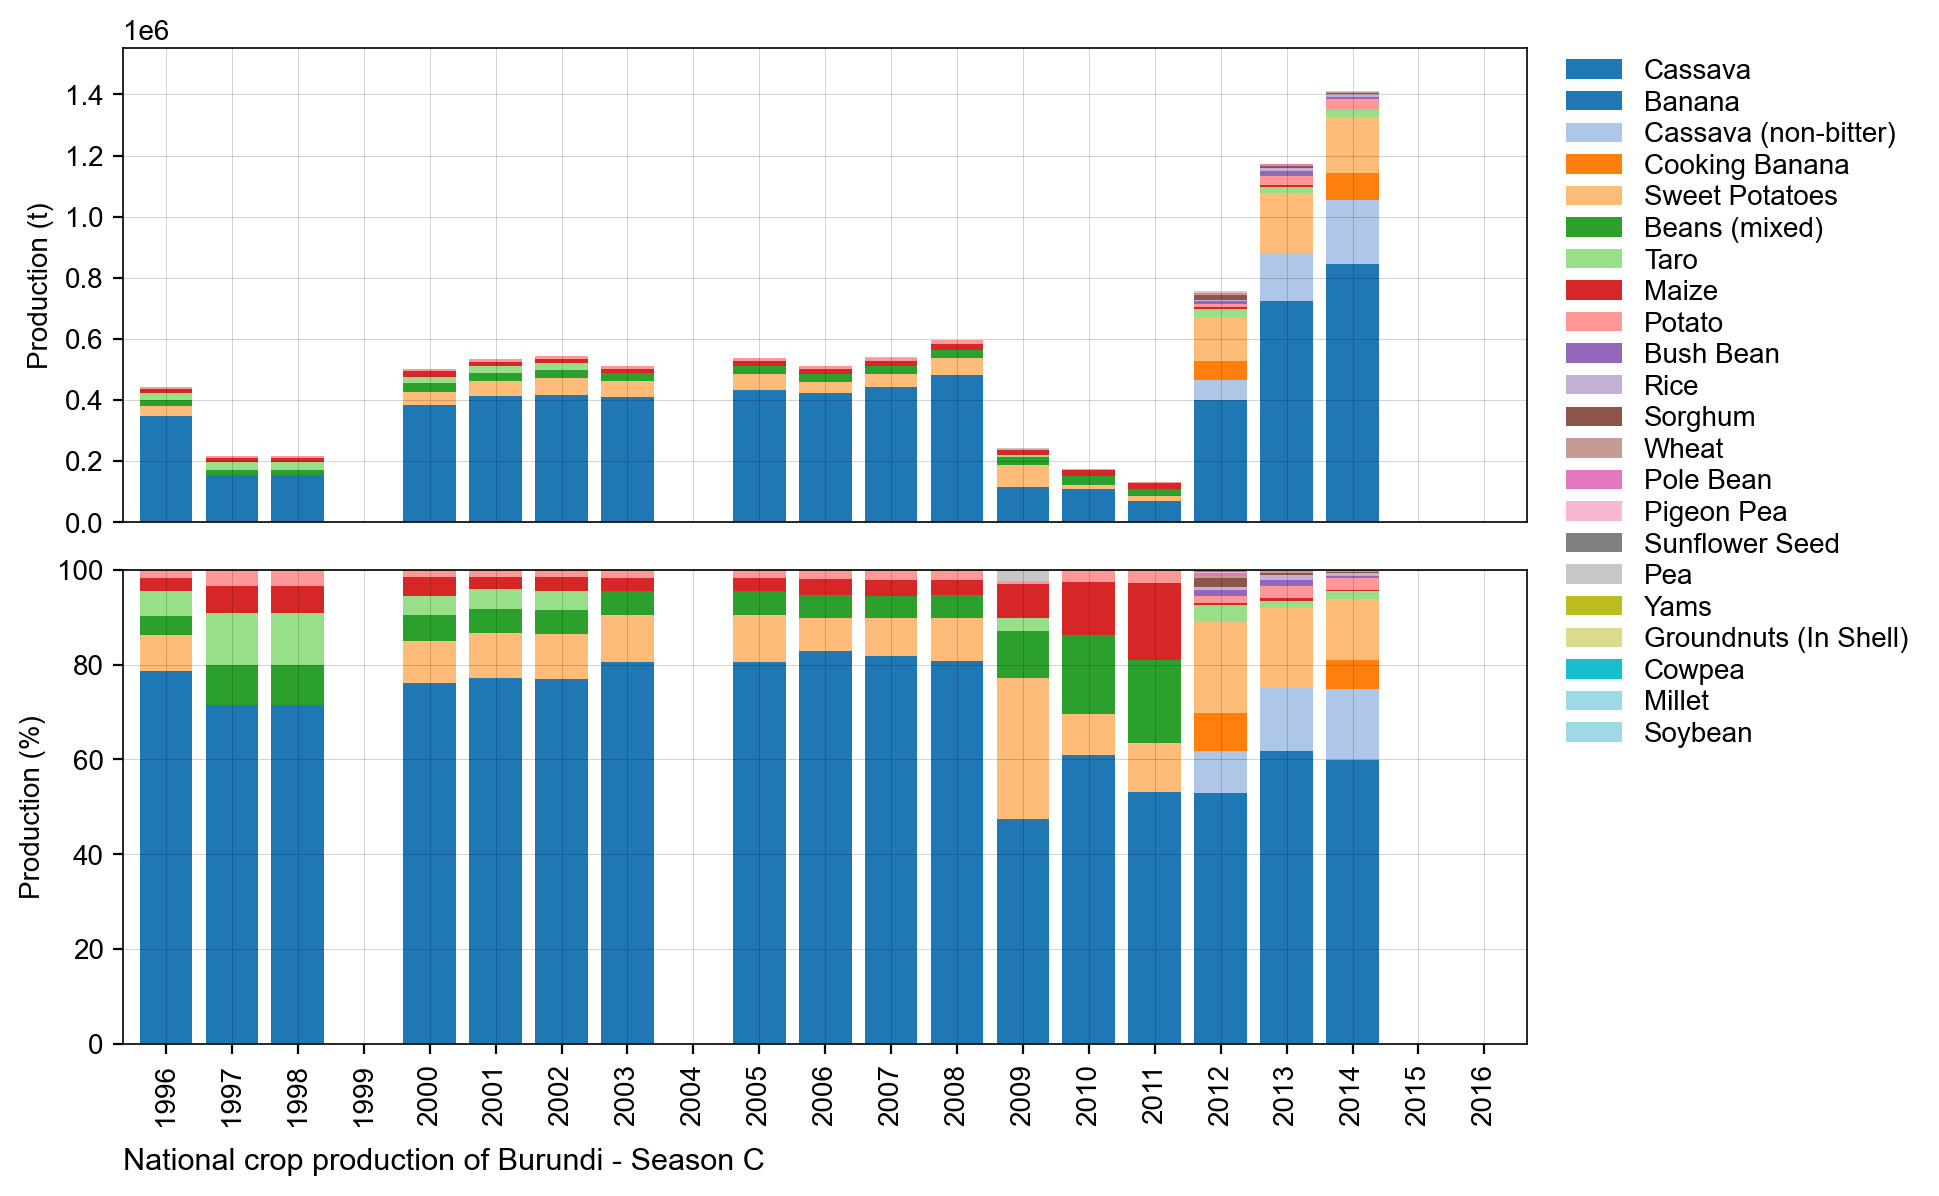

../figures/BI_bar_natgrainprod_Season C.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'BI', 'Burundi'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Season A','Season B','Season C']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

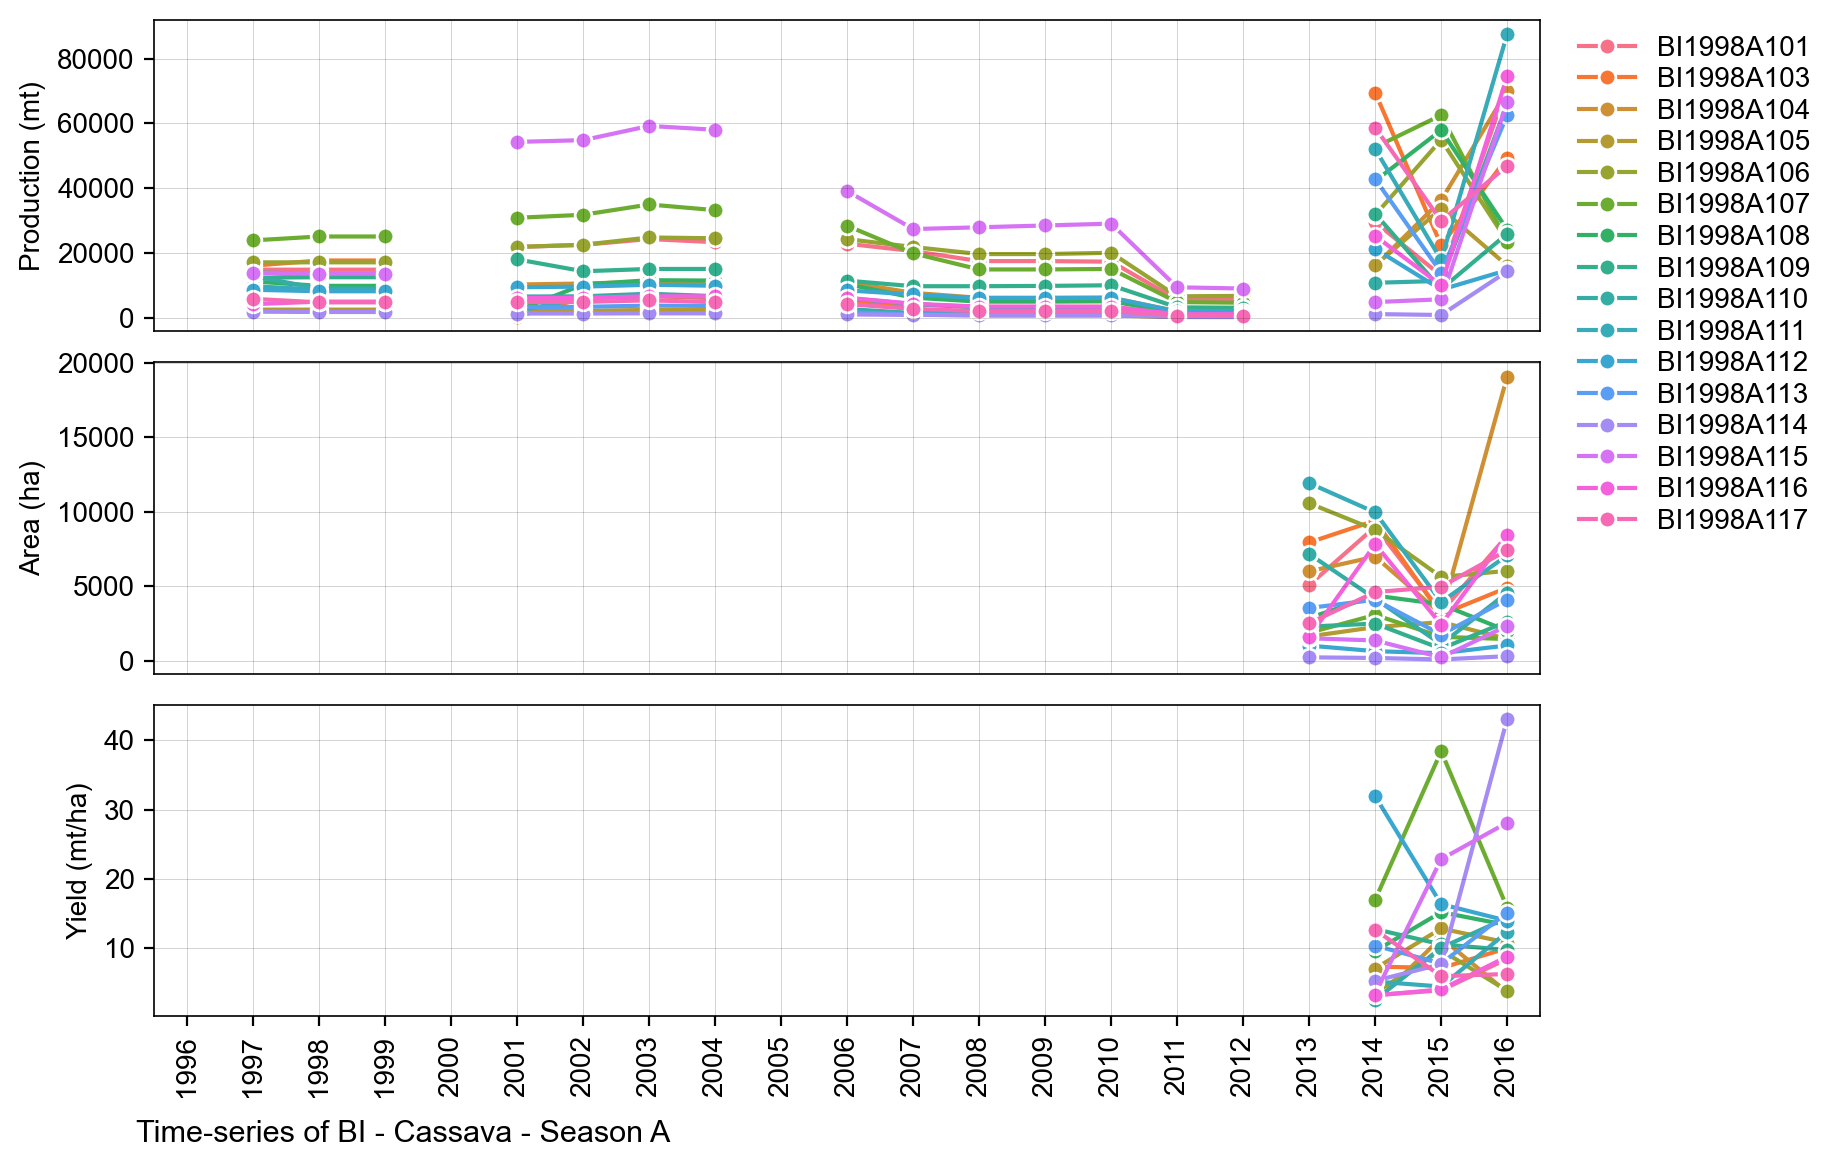

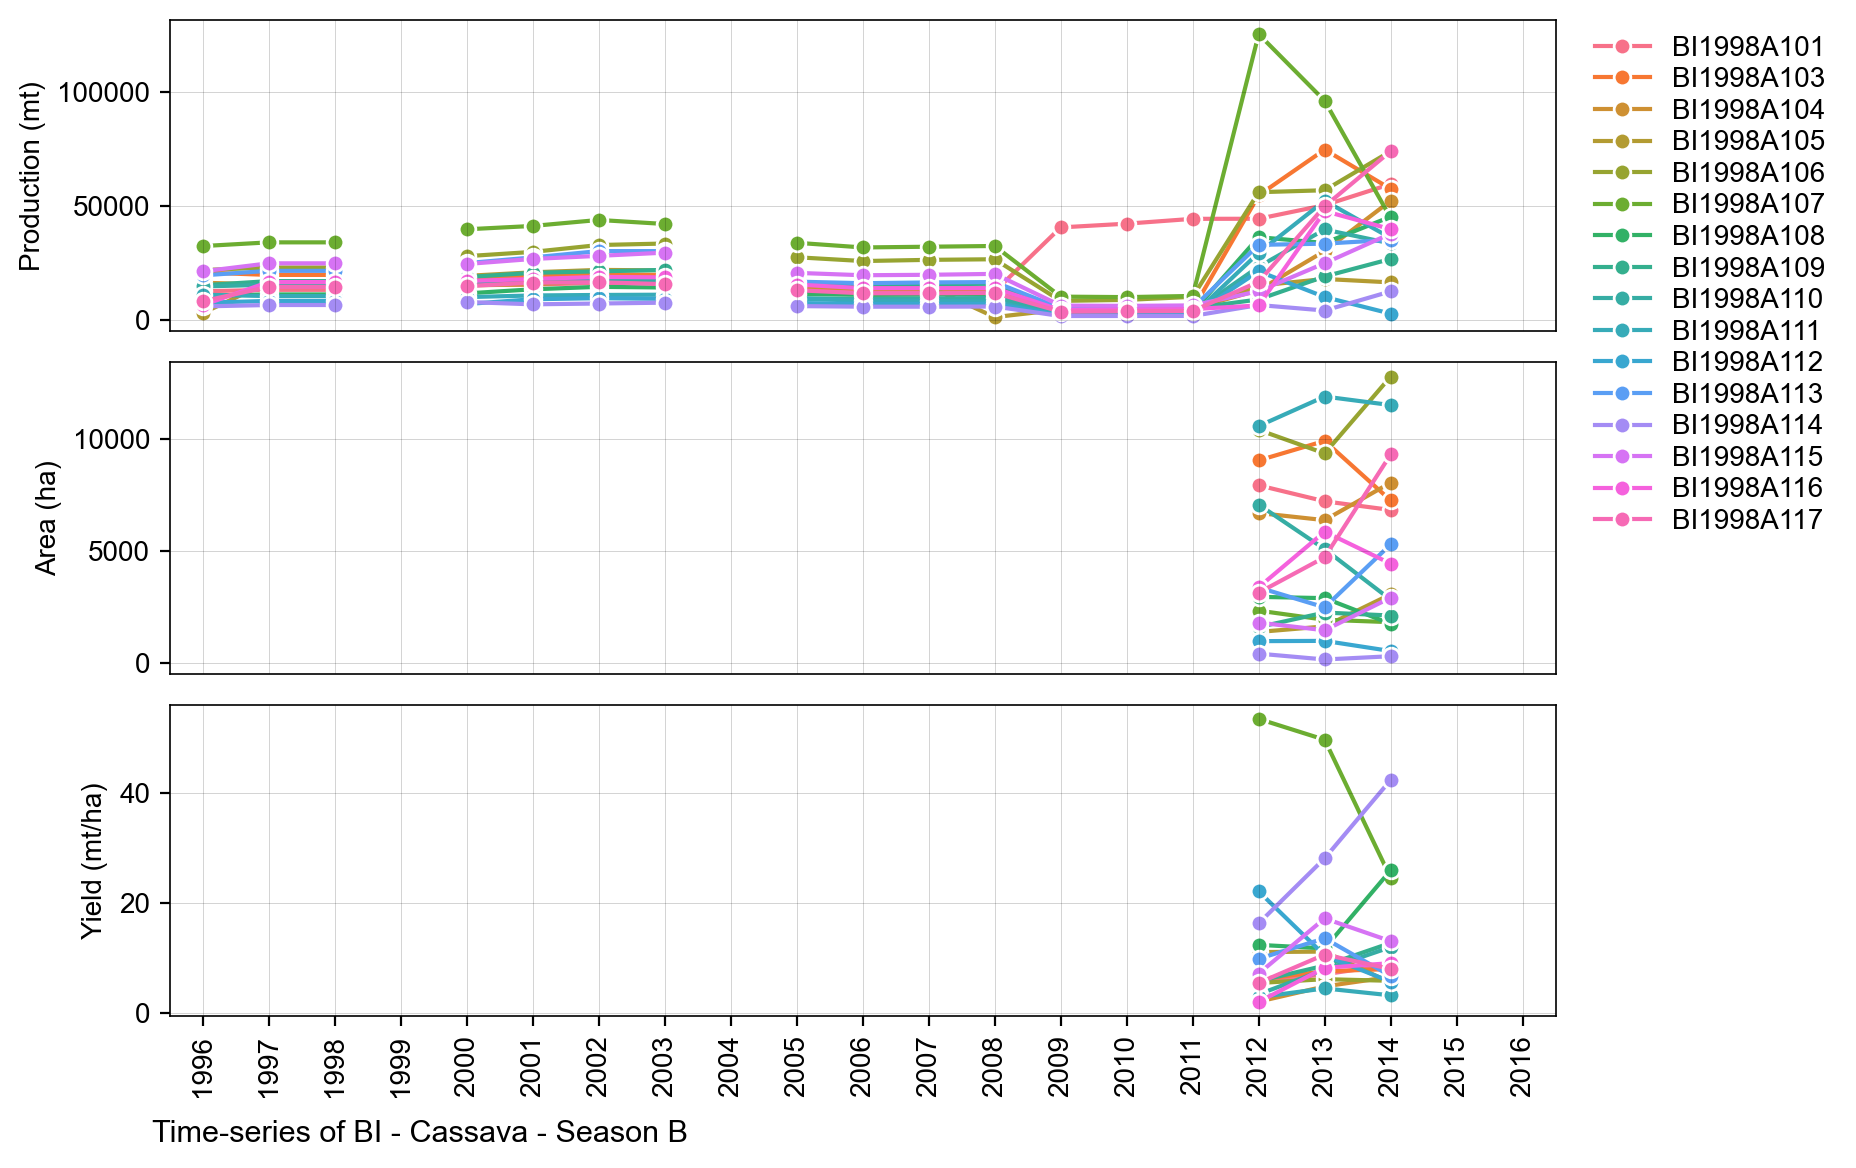

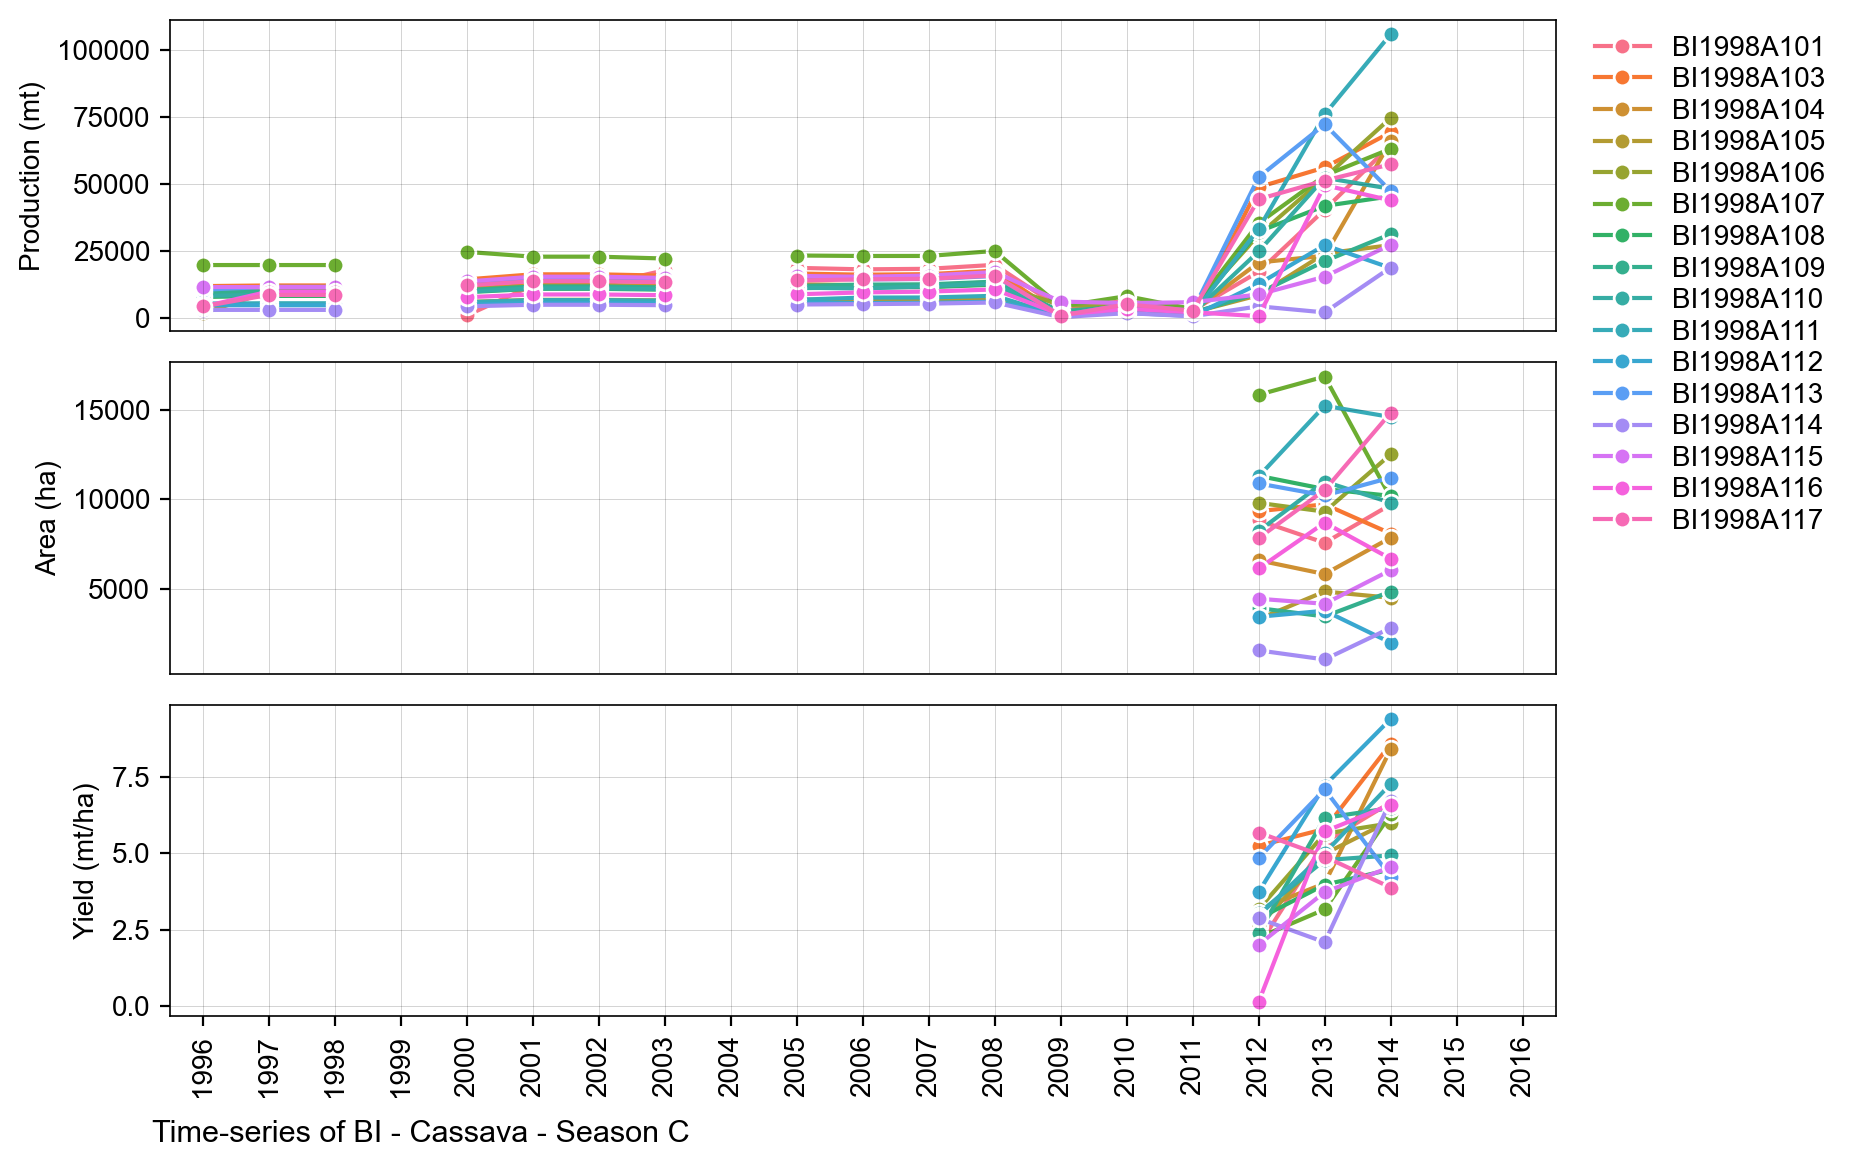

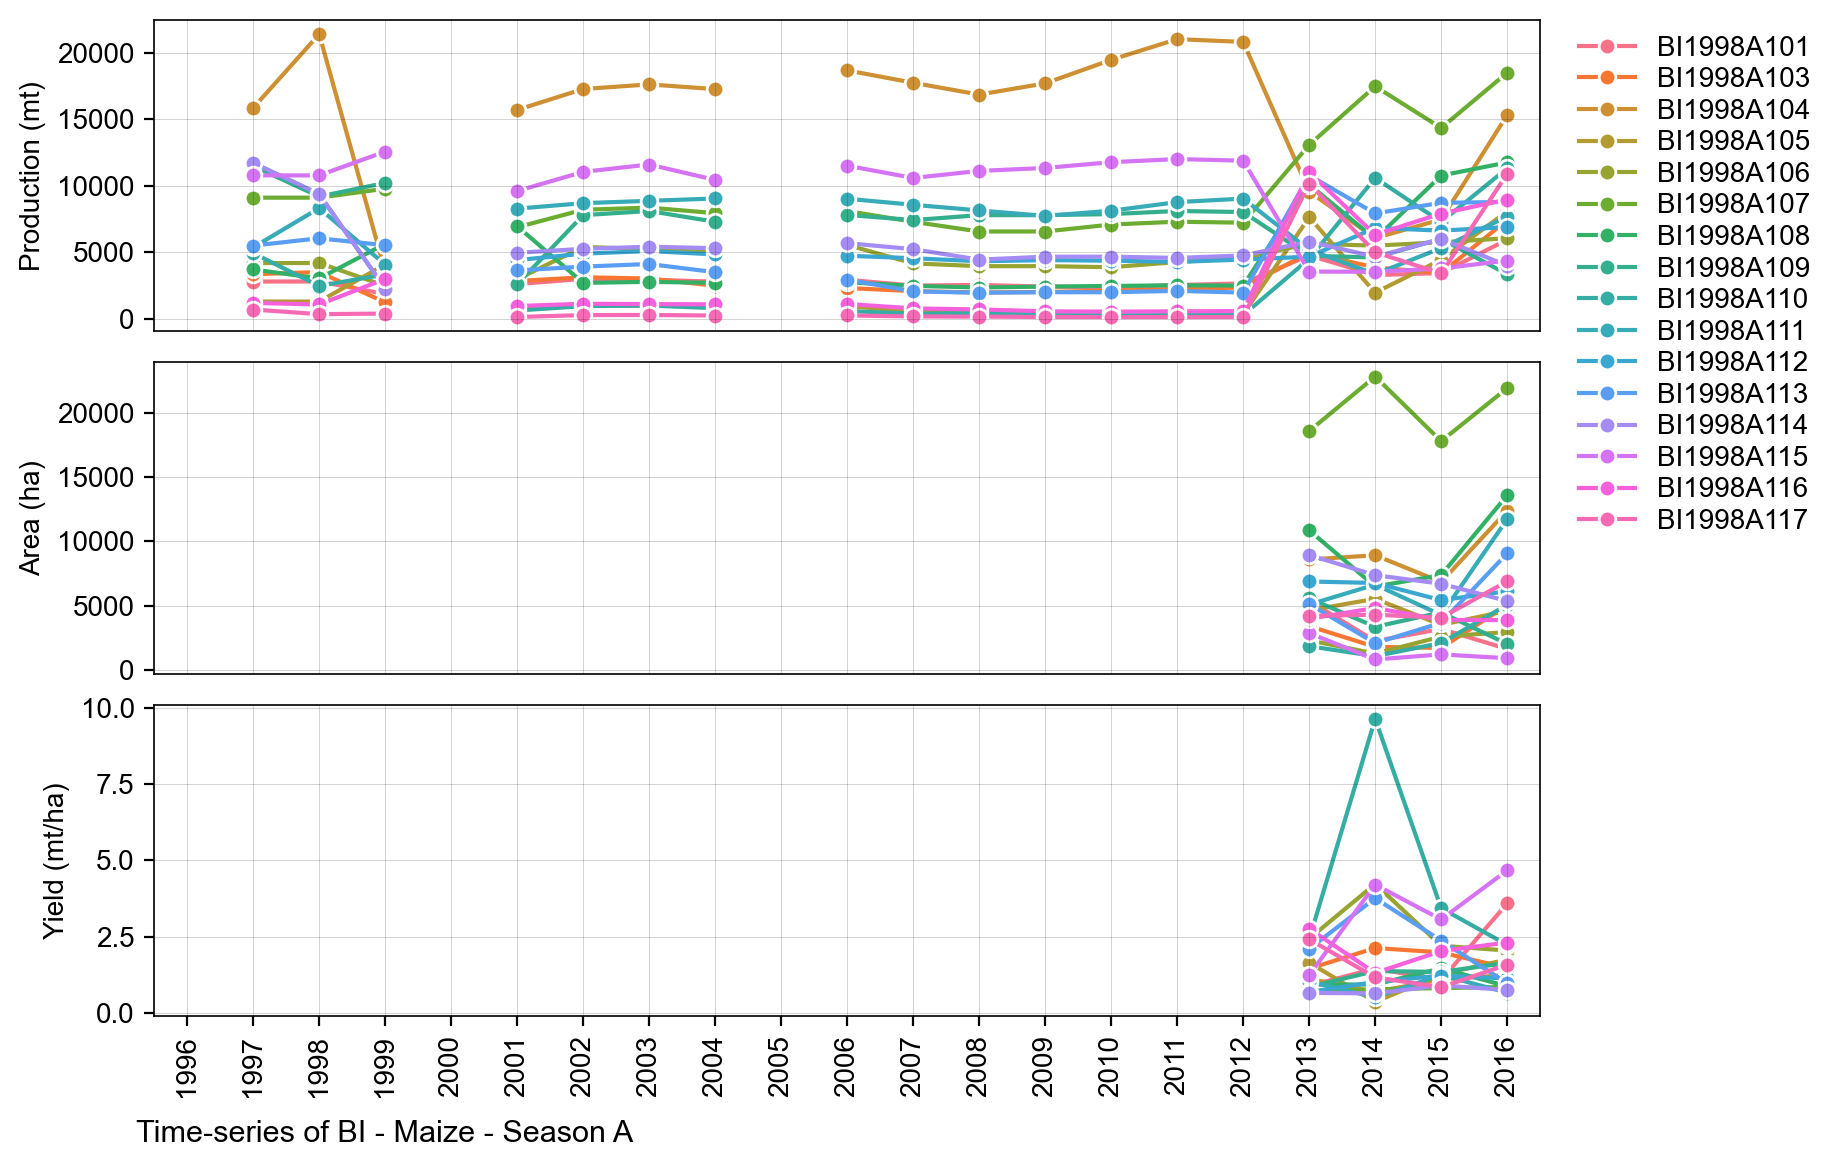

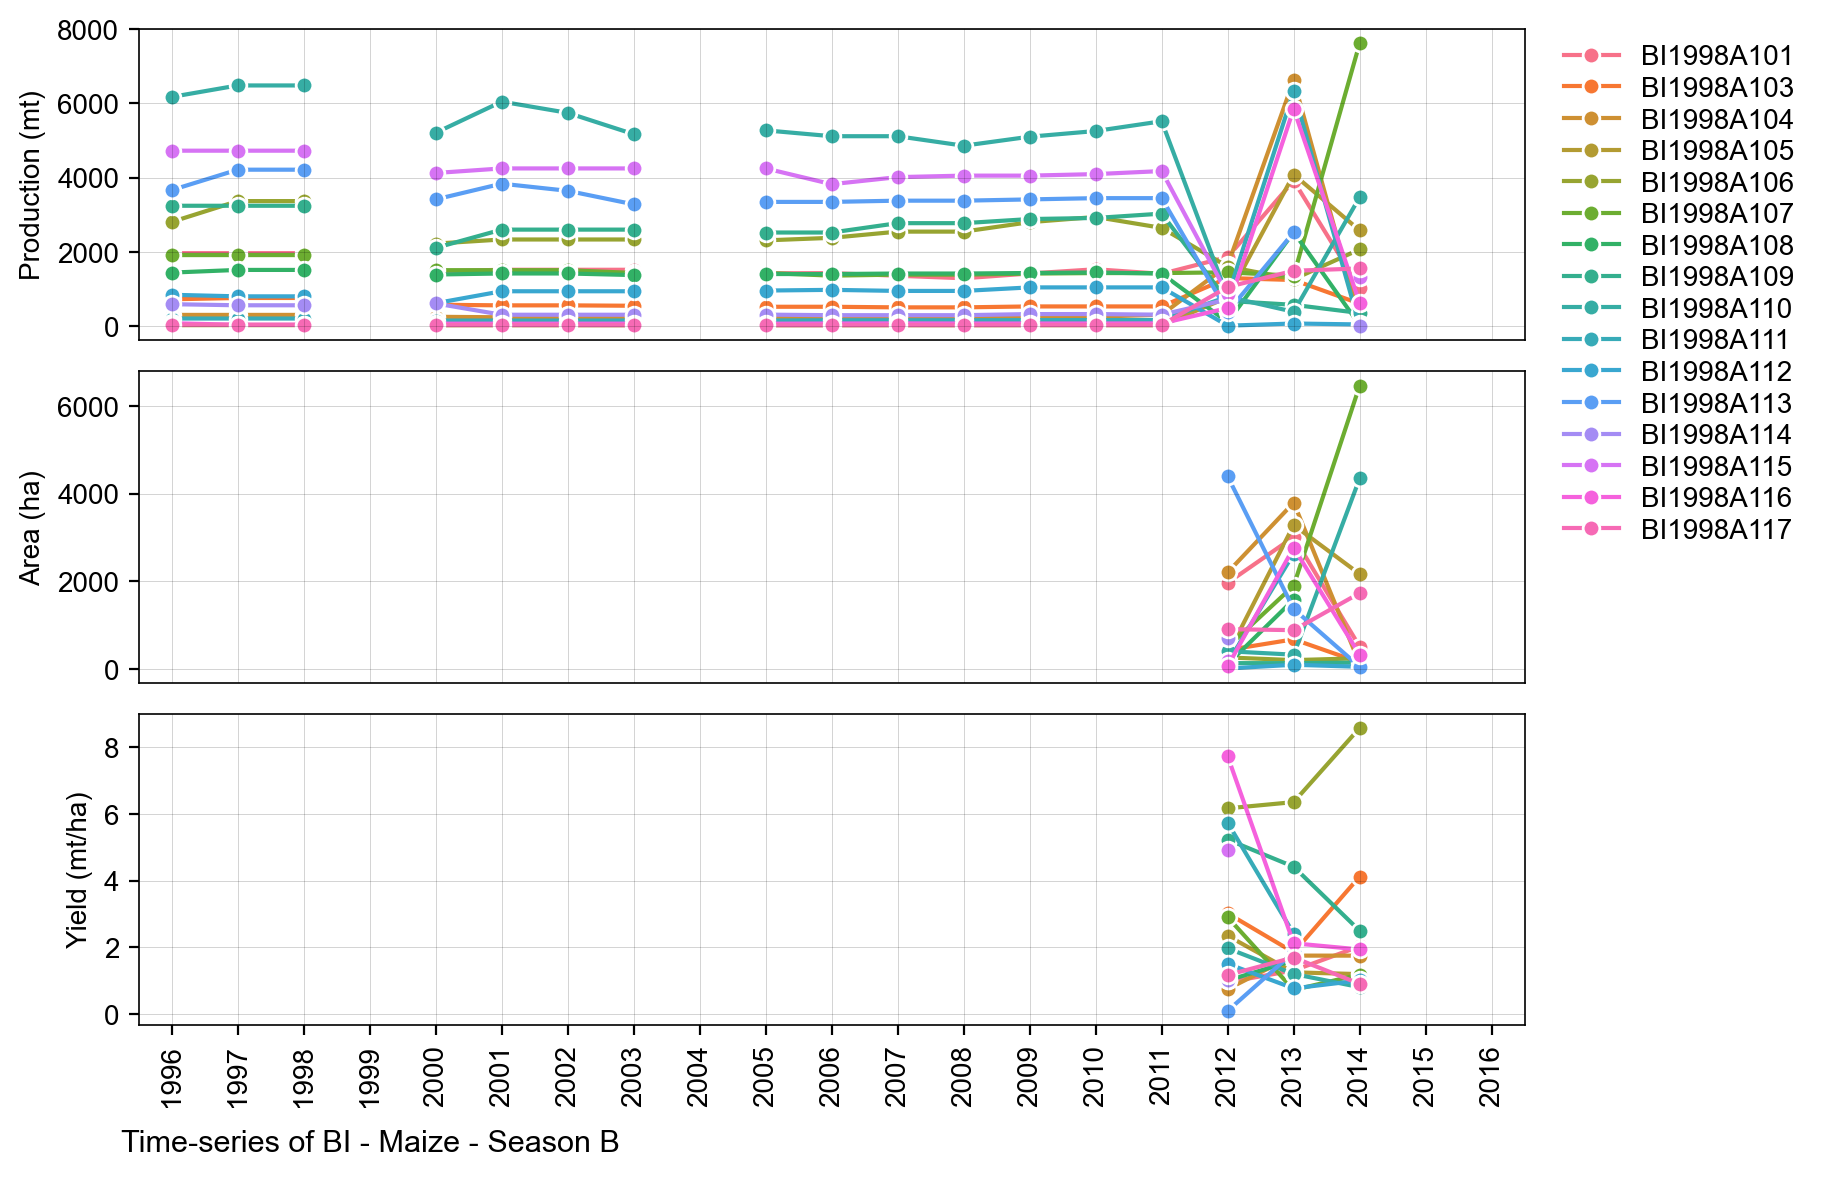

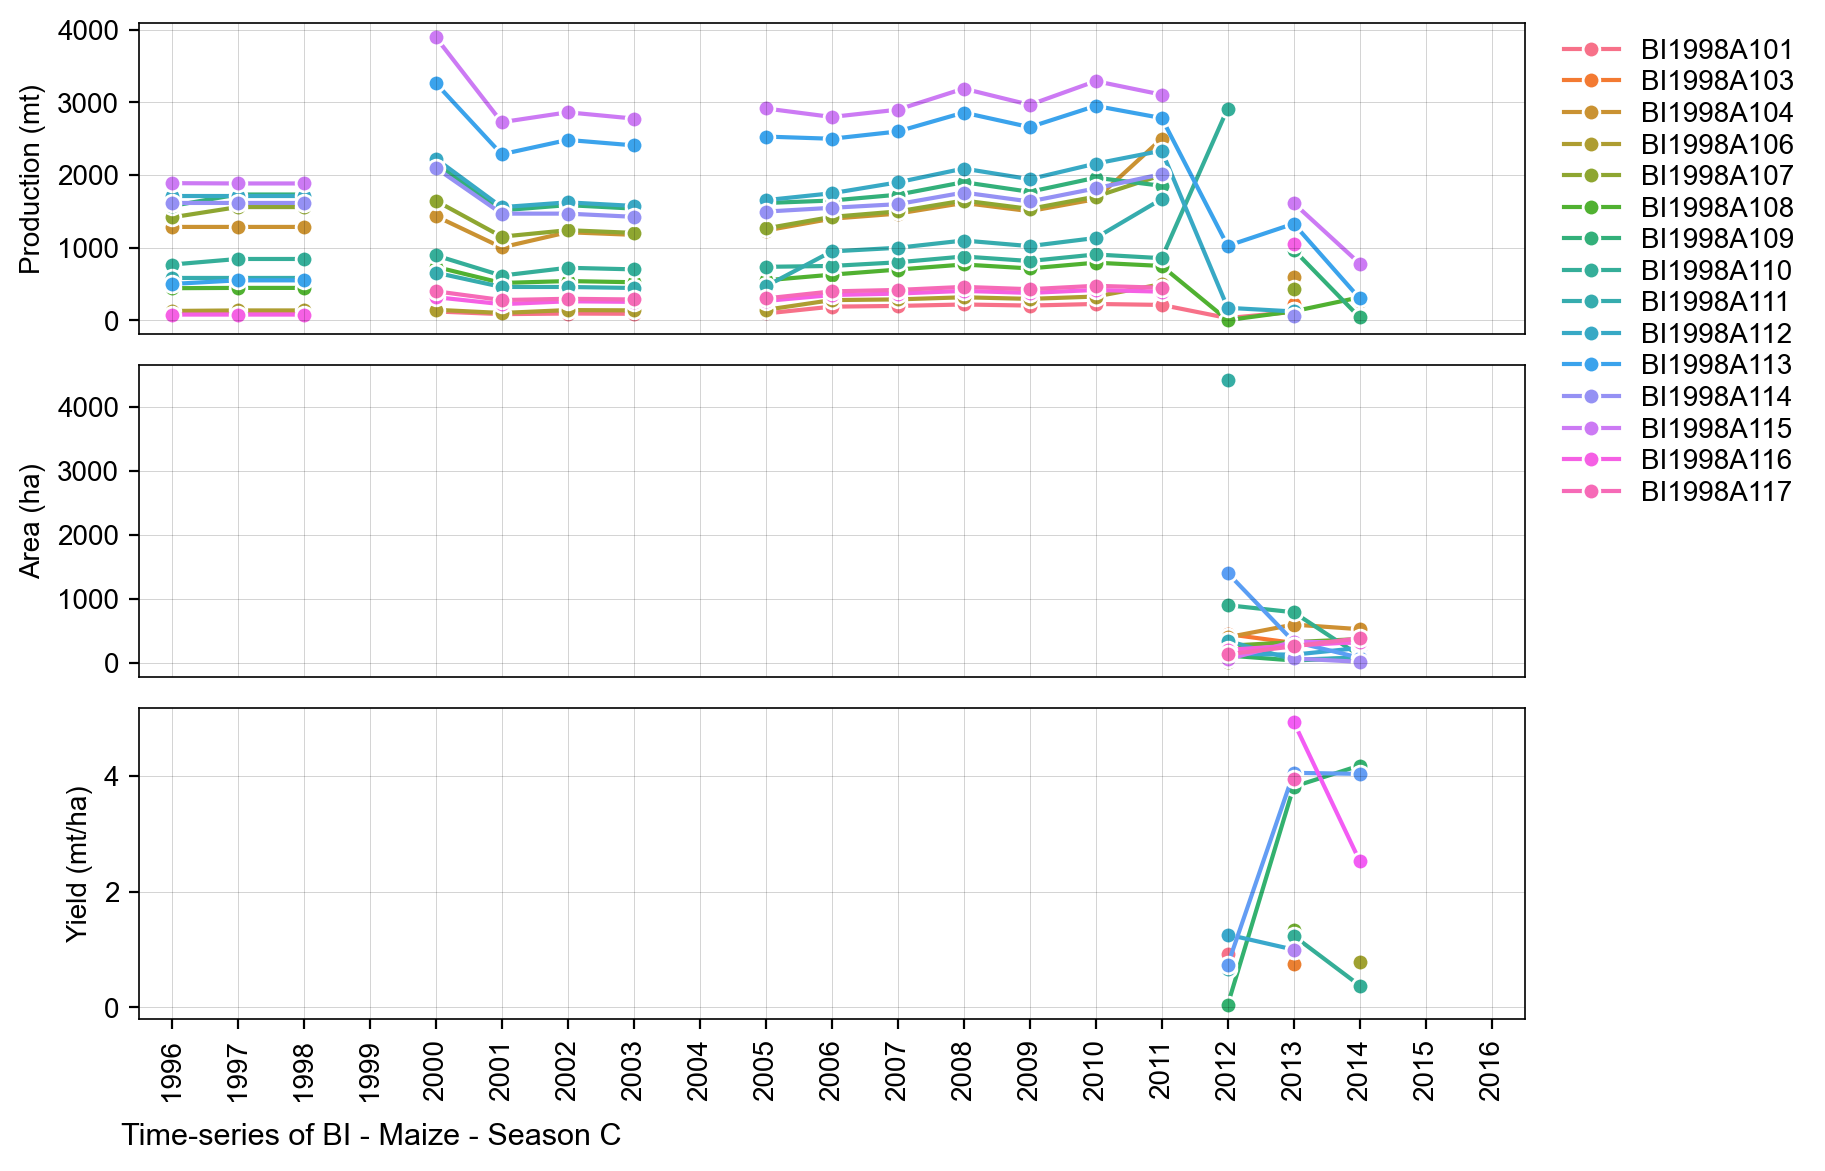

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'BI', 'Burundi'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava', 'Season A'],
    ['Cassava', 'Season B'],
    ['Cassava', 'Season C'],
    ['Maize', 'Season A'],
    ['Maize', 'Season B'],
    ['Maize', 'Season C'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub['year'].unique()) < 1: continue
    PlotLinePAY(sub, year, footnote)